In [2]:
import pandas as pd
import seaborn as sns
%pylab inline
pd.set_option('display.max_columns',None)
pd.options.display.max_seq_items = 2000
##pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import requests, re
import pandas as pd
import seaborn as sns
import nltk
import string, itertools
from collections import Counter, defaultdict
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from sklearn.cluster import KMeans
from wordcloud import WordCloud

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Clean Yelp_business dataset 

In [5]:
business = pd.read_csv('yelp_business.csv')
business.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [6]:
## drop unuseful column 'neighborhood' 
business.drop(['neighborhood'], axis=1, inplace=True)

## remove quotation marks in name and address column
business.name=business.name.str.replace('"','')
business.address=business.address.str.replace('"','')

## filter restaurants of US
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
usa=business.loc[business['state'].isin(states)]
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,Dental by Design,"4855 E Warner Rd, Ste B9",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,Stephen Szabo Salon,3101 Washington Rd,McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,Western Motor Vehicle,"6025 N 27th Ave, Ste 1",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,Sports Authority,"5000 Arizona Mills Cr, Ste 435",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [11]:
## select all restaurants in USA
us_restaurants=usa[usa['categories'].str.contains('Restaurants')]

## select out 16 cuisine types of restaurants and rename the category
us_restaurants.is_copy=False
us_restaurants['category']=pd.Series()
us_restaurants.loc[us_restaurants.categories.str.contains('American'),'category'] = 'American'
us_restaurants.loc[us_restaurants.categories.str.contains('Mexican'), 'category'] = 'Mexican'
us_restaurants.loc[us_restaurants.categories.str.contains('Italian'), 'category'] = 'Italian'
us_restaurants.loc[us_restaurants.categories.str.contains('Japanese'), 'category'] = 'Japanese'
us_restaurants.loc[us_restaurants.categories.str.contains('Chinese'), 'category'] = 'Chinese'
us_restaurants.loc[us_restaurants.categories.str.contains('Thai'), 'category'] = 'Thai'
us_restaurants.loc[us_restaurants.categories.str.contains('Mediterranean'), 'category'] = 'Mediterranean'
us_restaurants.loc[us_restaurants.categories.str.contains('French'), 'category'] = 'French'
us_restaurants.loc[us_restaurants.categories.str.contains('Vietnamese'), 'category'] = 'Vietnamese'
us_restaurants.loc[us_restaurants.categories.str.contains('Greek'),'category'] = 'Greek'
us_restaurants.loc[us_restaurants.categories.str.contains('Indian'),'category'] = 'Indian'
us_restaurants.loc[us_restaurants.categories.str.contains('Korean'),'category'] = 'Korean'
us_restaurants.loc[us_restaurants.categories.str.contains('Hawaiian'),'category'] = 'Hawaiian'
us_restaurants.loc[us_restaurants.categories.str.contains('African'),'category'] = 'African'
us_restaurants.loc[us_restaurants.categories.str.contains('Spanish'),'category'] = 'Spanish'
us_restaurants.loc[us_restaurants.categories.str.contains('Middle_eastern'),'category'] = 'Middle_eastern'
us_restaurants.category[:20]

C:\Users\Asus\AppData\Local\Temp\ipykernel_14236\4256751099.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  us_restaurants['category']=pd.Series()
C:\Users\Asus\AppData\Local\Temp\ipykernel_14236\4256751099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_restaurants['category']=pd.Series()
C:\Users\Asus\AppData\Local\Temp\ipykernel_14236\4256751099.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

4     American
10         NaN
14    American
28         NaN
29    American
40    Japanese
44     Italian
45         NaN
46         NaN
52    American
53         NaN
54    American
64         NaN
72         NaN
75         NaN
76         NaN
80         NaN
81    American
88         NaN
91     Italian
Name: category, dtype: object

In [12]:
## drop null values in category, delete original column categories and reset the index
us_restaurants=us_restaurants.dropna(axis=0, subset=['category'])
del us_restaurants['categories']
us_restaurants=us_restaurants.reset_index(drop=True)
us_restaurants.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,category
0,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American
1,fNMVV_ZX7CJSDWQGdOM8Nw,Showmars Government Center,600 E 4th St,Charlotte,NC,28202,35.221647,-80.839345,3.5,7,1,American
2,gAy4LYpsScrj8POnCW6btQ,Toast Cafe,2429 Hwy 160 W,Fort Mill,SC,29708,35.047287,-80.990559,3.5,6,0,American
3,tRVx2c89coruPRwYhGTcTw,Yuzu,13603 Madison Ave,Lakewood,OH,44107,41.476846,-81.786971,3.5,78,1,Japanese
4,BnuzcebyB1AfxH0kjNWqSg,Carrabba's Italian Grill,245 Lancaster Ave,Frazer,PA,19355,40.041003,-75.542497,3.5,25,0,Italian
5,Pd52CjgyEU3Rb8co6QfTPw,Flight Deck Bar & Grill,6730 S Las Vegas Blvd,Las Vegas,NV,89119,36.066914,-115.170848,4.0,13,1,American
6,n7V4cD-KqqE3OXk0irJTyA,GameWorks,"6587 Las Vegas Blvd S, Ste 171",Las Vegas,NV,89119,36.068259,-115.178877,3.0,349,1,American
7,B5EZlEDH6AVDk8tQGHAGqg,Villa Tap,2302 Packers Ave,Madison,WI,53704,43.123389,-89.355390,4.0,34,1,American
8,F0fEKpTk7gAmuSFI0KW1eQ,Cafe Mastrioni,"4250 S Rainbow Blvd, Ste 1007",Las Vegas,NV,89103,36.111057,-115.241688,1.5,3,0,Italian
9,VdlPZg2NAu8t8GkdbPLecg,Tandoori Times Indian Bistro,"8140 N Hayden Rd, Ste H115",Scottsdale,AZ,85258,33.555212,-111.900456,3.5,263,1,Indian


In [13]:
## check total number of us restaurants
us_restaurants.shape

(19156, 12)

In [14]:
## check whether has duplicated business id
us_restaurants.business_id.duplicated().sum()

0

In [15]:
## check the datatype
us_restaurants.dtypes

business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
category         object
dtype: object

In [16]:
## check missing values
us_restaurants.isnull().sum()

business_id      0
name             0
address          0
city             0
state            0
postal_code     22
latitude         0
longitude        0
stars            0
review_count     0
is_open          0
category         0
dtype: int64

### Clean yelp_review dataset

In [17]:
## load review table
review = pd.read_csv('yelp_review.csv')
review.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [18]:
## check missing values
review.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
date           0
text           0
useful         0
funny          0
cool           0
dtype: int64

In [19]:
## check duplicates of review_id
review.review_id.duplicated().sum()

0

### Merge two datasets and get new dataframe restaurants_reviews

In [20]:
## merge business table and review table
restaurants_reviews = pd.merge(us_restaurants, review, on = 'business_id')

## update column names
restaurants_reviews.rename(columns={'stars_x':'avg_star','stars_y':'review_star'}, inplace=True)

## add column of number of words in review and label of negative and postive reviews
restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','').map(lambda x: len(x.split()))
    

C:\Users\Asus\AppData\Local\Temp\ipykernel_14236\2905545444.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n',''). \


In [21]:
## add column of number of words in review and label of negative and postive reviews
restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','').map(lambda x: len(x.split()))

C:\Users\Asus\AppData\Local\Temp\ipykernel_14236\1154942041.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n',''). \


In [22]:
# label reviews as positive or negative
restaurants_reviews['labels'] = ''
restaurants_reviews.loc[restaurants_reviews.review_star >=4, 'labels'] = 'positive'
restaurants_reviews.loc[restaurants_reviews.review_star ==3, 'labels'] = 'neural'
restaurants_reviews.loc[restaurants_reviews.review_star <3, 'labels'] = 'negative'

# drop neutral reviews for easy analysis
restaurants_reviews.drop(restaurants_reviews[restaurants_reviews['labels'] =='neural'].index, axis=0, inplace=True)
restaurants_reviews.reset_index(drop=True, inplace=True)

restaurants_reviews.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,is_open,category,review_id,user_id,review_star,date,text,useful,funny,cool,num_words_review,labels
0,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.47569,3.5,116,1,American,rnvu74aNIPn93Z9Ue11Epw,bgtr7jOlALe8ay4g7pnf4A,4,2016-05-05,I've always enjoyed my time at brick house foo...,0,0,0,37,positive
1,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.47569,3.5,116,1,American,OE5dH664oSSK_-TvIl263w,ndZOHkG_FWdL4TRd9xRfNQ,2,2017-03-19,1st time here. Came w my Unc bc Louies was clo...,0,0,0,60,negative
2,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.47569,3.5,116,1,American,SWeHmo8uHHWbbv94VdAMeQ,UqtE83J-6NMQNNJzpnWwEQ,1,2015-08-31,Worse service ever andI use to be a server so ...,0,0,0,106,negative
3,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.47569,3.5,116,1,American,fCCL0pAgYGccUs8shHHIUA,PixAmdRa58XZ3hr8YLS36g,5,2015-10-09,I am updating my review to 5-stars because I t...,2,0,2,498,positive
4,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.47569,3.5,116,1,American,-VOh0NNnIo1r24hjwSZL4Q,Hly0NEWXMxbuXa2zm_NJOQ,4,2015-01-15,I enjoyed this place. I went the night the Bu...,0,0,0,56,positive


## Exploratory Data Analysis

### Restaurants Distribution

#### Distribution of restaurants in each category

In [23]:
plt.style.use('ggplot')

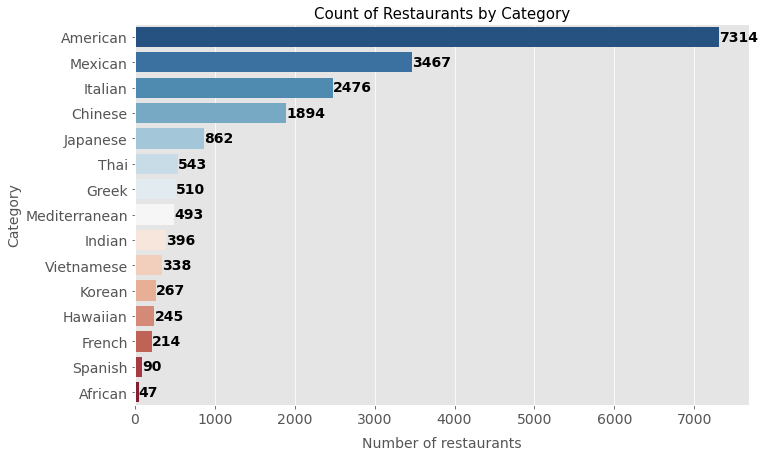

In [24]:
plt.figure(figsize=(11,7))
grouped = us_restaurants.category.value_counts()
sns.countplot(y='category',data=us_restaurants, 
              order = grouped.index, palette= sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Number of restaurants', fontsize=14, labelpad=10)
plt.ylabel('Category', fontsize=14)
plt.title('Count of Restaurants by Category', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(us_restaurants.category.value_counts()):
    plt.text(v, i+0.15, str(v), fontweight='bold', fontsize=14)

Categories in dark blue color have the largest number of restaurants. On the contrary, categories in dark red color have the least number of restaurants. The top 5 type of restaurants are American, Mexican, Italian, Chinese and Japanese. 

#### Top 10 cities with most restaurants

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


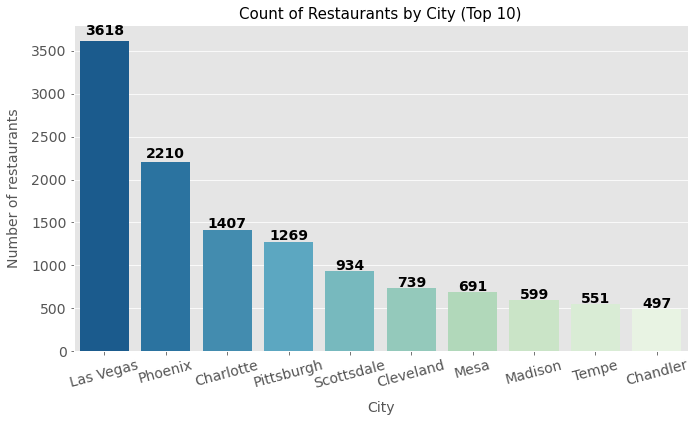

In [25]:
plt.figure(figsize=(11,6))
grouped = us_restaurants.city.value_counts()[:10]
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("GnBu_r", len(grouped)))
plt.ylabel('Number of restaurants', fontsize=14, labelpad=10)
plt.xlabel('City', fontsize=14, labelpad=10)
plt.title('Count of Restaurants by City (Top 10)', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

#### Distribution of restaurants in each state

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


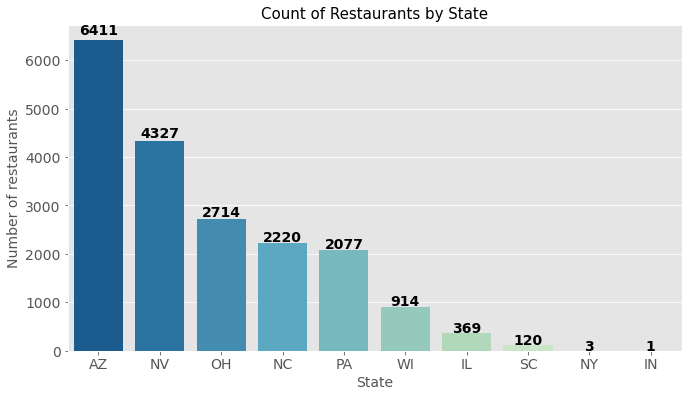

In [26]:
plt.figure(figsize=(11,6))
grouped = us_restaurants.state.value_counts()
sns.barplot(grouped.index, grouped.values,palette=sns.color_palette("GnBu_r", len(grouped)) )
plt.ylabel('Number of restaurants', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.title('Count of Restaurants by State', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center', fontweight='bold', fontsize=14)

### Reviews Distribution

#### Distribution of reviews by cuisine type

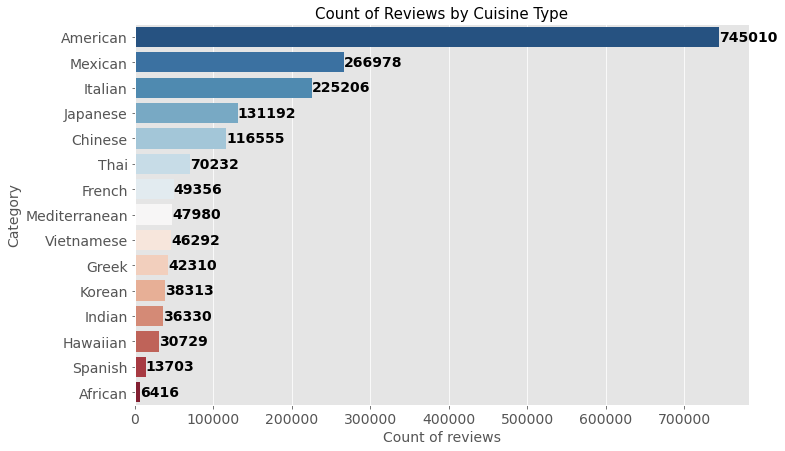

In [27]:
plt.figure(figsize=(11,7))
grouped = us_restaurants.groupby('category')['review_count'].sum().sort_values(ascending = False)
sns.barplot(y=grouped.index, x= grouped.values, palette= sns.color_palette("RdBu_r", len(grouped)) )
plt.ylabel('Category', fontsize=14)
plt.xlabel('Count of reviews', fontsize=14)
plt.title('Count of Reviews by Cuisine Type', fontsize=15)
for i,v in enumerate(grouped):
    plt.text(v, i+0.15, str(v),fontweight='bold', fontsize=14)
plt.tick_params(labelsize=14)

#### Top 10 cities with most reviews

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


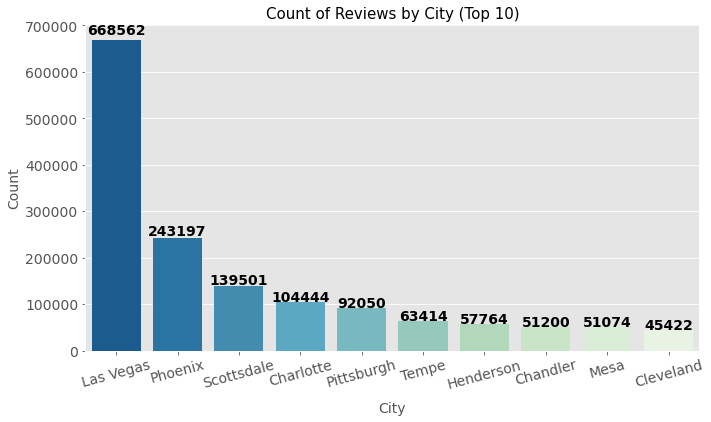

In [28]:
plt.figure(figsize=(11,6))
grouped = us_restaurants.groupby('city')['review_count'].sum().sort_values(ascending=False)[:10]
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("GnBu_r", len(grouped)) )
plt.xlabel('City', labelpad=10, fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Reviews by City (Top 10)', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

#### Top 9 restaurants with most reviews

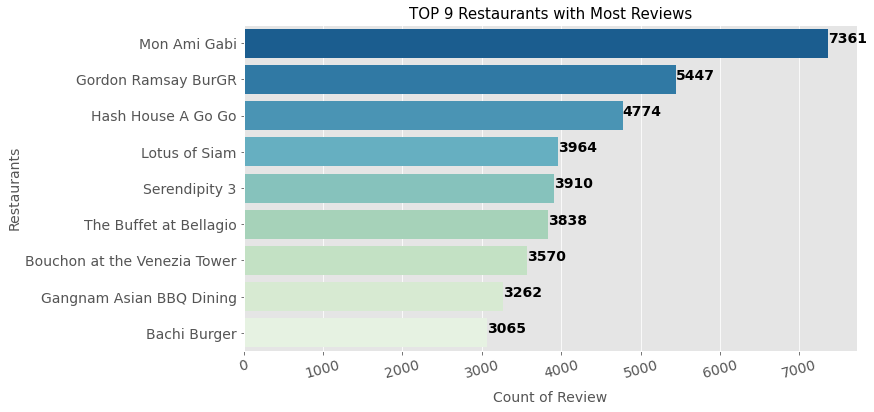

In [29]:
plt.figure(figsize=(11,6))
grouped = us_restaurants[['name','review_count']].sort_values(by='review_count', ascending=False)[:9]
sns.barplot(x=grouped.review_count, y = grouped.name, palette=sns.color_palette("GnBu_r", len(grouped)), ci=None)
plt.xlabel('Count of Review', labelpad=10, fontsize=14)
plt.ylabel('Restaurants', fontsize=14)
plt.title('TOP 9 Restaurants with Most Reviews', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped.review_count):
    plt.text(v, i, str(v), fontweight='bold', fontsize=14)

#### Distribution of positive and negative reviews in each category

In [30]:
table = pd.pivot_table(restaurants_reviews, values=["review_id"], index=["category"],columns=["labels"], 
                       aggfunc=len, margins=True, dropna=True,fill_value=0)
table_percentage = table.div( table.iloc[:,-1], axis=0).iloc[:-1,-2].sort_values(ascending=False)

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


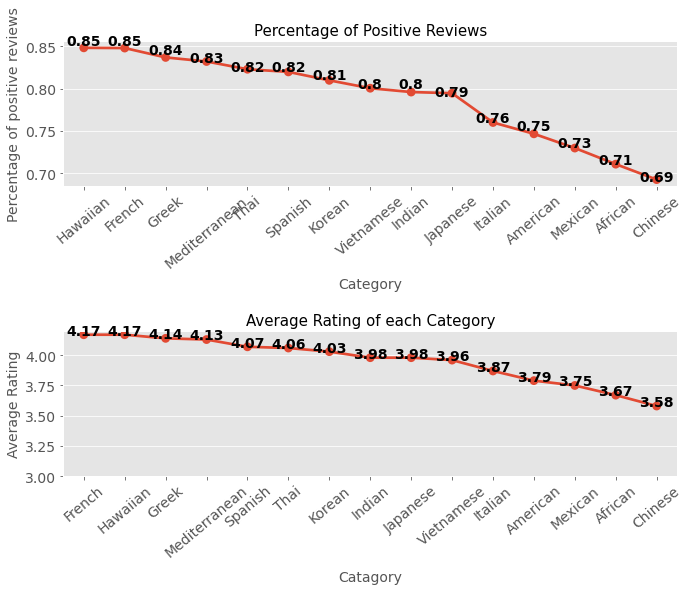

In [31]:
table = pd.pivot_table(restaurants_reviews, values=["review_id"], index=["category"],columns=["labels"], 
                       aggfunc=len, margins=True, dropna=True,fill_value=0)
table_percentage = table.div( table.iloc[:,-1], axis=0).iloc[:-1,-2].sort_values(ascending=False)
plt.figure(figsize=(11,8))
plt.subplot(211)
sns.pointplot(x=table_percentage.index, y= table_percentage.values)
plt.xlabel('Category', labelpad=7, fontsize=14)
plt.ylabel('Percentage of positive reviews', fontsize=14)
plt.title('Percentage of Positive Reviews', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=40)
for  i, v in enumerate(table_percentage.round(2)):
    plt.text(i, v*1.001, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
    
plt.subplot(212)
grouped = restaurants_reviews.groupby('category')['review_star'].mean().round(2).sort_values(ascending=False)
sns.pointplot(grouped.index, grouped.values)
plt.ylim(3)
plt.xlabel('Catagory', labelpad=10, fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.title('Average Rating of each Category', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=40)
for  i, v in enumerate(grouped):
    plt.text(i, v, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
    
plt.subplots_adjust(hspace=1)

#### Average length of reviews

#### Average length of words in each category

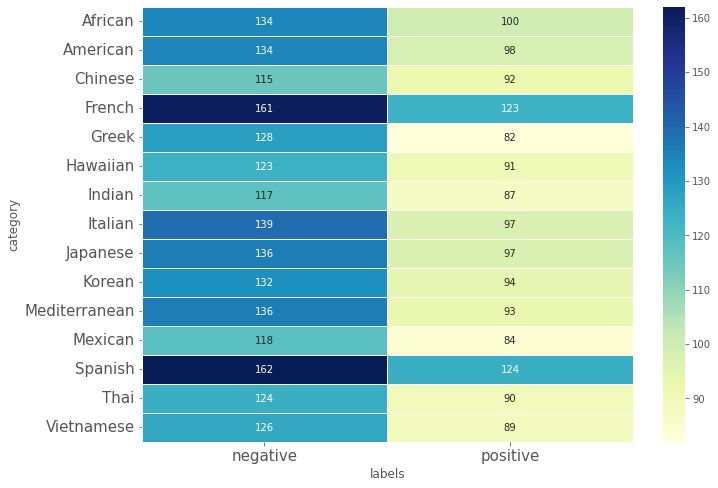

In [32]:
table = restaurants_reviews.groupby(['category','labels'])['num_words_review'].mean().round().unstack()
plt.figure(figsize=(11,8))
sns.heatmap(table, cmap='YlGnBu', fmt='g',annot=True, linewidths=1)
plt.tick_params(labelsize=15)

### Ratings Distribution

#### Distribution of ratings by restaurants

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


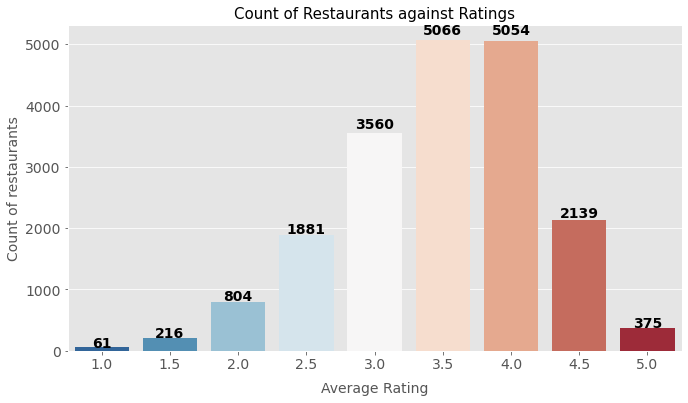

In [33]:
plt.figure(figsize=(11,6))
grouped = us_restaurants.stars.value_counts().sort_index()
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Average Rating', labelpad=10, fontsize=14)
plt.ylabel('Count of restaurants', fontsize=14)
plt.title('Count of Restaurants against Ratings', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

#### Distribution of ratings by reviews

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


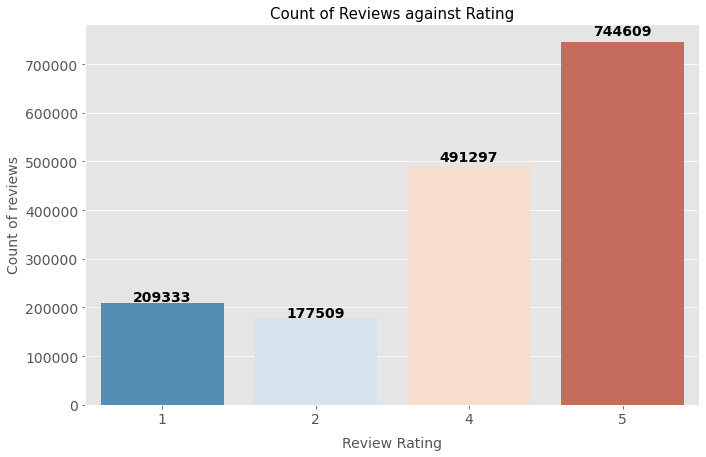

In [34]:
plt.figure(figsize=(11,7))
grouped = restaurants_reviews.review_star.value_counts().sort_index()
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Review Rating', labelpad=10, fontsize=14)
plt.ylabel('Count of reviews', fontsize=14)
plt.title('Count of Reviews against Rating', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

## Review Analysis

### Positive words and negative words

In [35]:
import csv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [36]:
## convert text to lower case
restaurants_reviews.text = restaurants_reviews.text.str.lower()

## remove unnecessary punctuation
restaurants_reviews['removed_punct_text']= restaurants_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','')


C:\Users\Asus\AppData\Local\Temp\ipykernel_14236\3171667963.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  restaurants_reviews['removed_punct_text']= restaurants_reviews.text.str.replace('\n',''). \


In [37]:
## import positive file which contains common meaningless positive words such as good
file_positive = open('positive.txt')
reader =csv.reader(file_positive)
positive_words = [word[0] for word in reader]

## import negative file which contains common meaningless positive words such as bad
file_negative = open('negative.txt')
reader =csv.reader(file_negative)
negative_words = [word[0] for word in reader]

In [38]:
## get dataset by category
def get_dataset(category):
    df = restaurants_reviews[['removed_punct_text','labels']][restaurants_reviews.category==category]
    df.reset_index(drop=True, inplace =True)
    df.rename(columns={'removed_punct_text':'text'}, inplace=True)
    return df



## only keep positive and negative words
def filter_words(review):
    words = [word for word in review.split() if word in positive_words + negative_words]
    words = ' '.join(words)
    return words

### Use Korean as an example 

In [39]:
Korean_reviews = get_dataset('Korean')

In [40]:
Korean_train, Korean_test = train_test_split(Korean_reviews[['text','labels']],test_size=0.5)

In [41]:
print('Total %d number of reviews' % Korean_train.shape[0])

Total 16796 number of reviews


In [42]:
def split_data(dataset, test_size):
    df_train, df_test = train_test_split(dataset[['text','labels']],test_size=test_size)
    return df_train

In [43]:
## filter words
Korean_train.text = Korean_train.text.apply(filter_words)

In [44]:
## construct features and labels
terms_train=list(Korean_train['text'])
class_train=list(Korean_train['labels'])

terms_test=list(Korean_test['text'])
class_test=list(Korean_test['labels'])

In [45]:
## get bag of words : the frequencies of various words appeared in each review
vectorizer = CountVectorizer()
feature_train_counts=vectorizer.fit_transform(terms_train)
feature_train_counts.shape

(16796, 2707)

In [46]:
## run model
svm = LinearSVC()
svm.fit(feature_train_counts, class_train)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

Support Vector Machine (SVM) model was applied to differentiate positive and
negative words in reviews, and further to get a word score to understand how positive or how negative the words are.

### Now we can calculate polarity score of each word in the specific category

#### Korean

In [47]:
## create dataframe for score of each word in a review calculated by svm model
coeff = svm.coef_[0]
Korean_words_score = pd.DataFrame({'score': coeff, 'word': vectorizer.get_feature_names()})

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [48]:
## get frequency of each word in all reviews in specific category
Korean_reviews = pd.DataFrame(feature_train_counts.toarray(), columns=vectorizer.get_feature_names())
Korean_reviews['labels'] = class_train
Korean_frequency = Korean_reviews[Korean_reviews['labels'] =='positive'].sum()[:-1]

In [49]:
Korean_words_score.set_index('word', inplace=True)

In [50]:
Korean_polarity_score = Korean_words_score
Korean_polarity_score['frequency'] = Korean_frequency

In [51]:
## calculate polarity score 
Korean_polarity_score['polarity'] = Korean_polarity_score.score * Korean_polarity_score.frequency / Korean_reviews.shape[0]

In [52]:
## drop unnecessary words
unuseful_positive_words = Korean_polarity_score.loc[['great','amazing','love','best','awesome','excellent','good',
                                                    'favorite','loved','perfect','gem','perfectly','wonderful',
                                                    'happy','enjoyed','nice','well','super','like','better','decent','fine',
                                                    'pretty','enough','excited','impressed','ready','fantastic','glad','right',
                                                    'fabulous']]
unuseful_negative_words =  Korean_polarity_score.loc[['bad','disappointed','unfortunately','disappointing','horrible',
                                                     'lacking','terrible','sorry', 'disappoint']]

Korean_polarity_score.drop(unuseful_positive_words.index, axis=0, inplace=True)
Korean_polarity_score.drop(unuseful_negative_words.index, axis=0, inplace=True)

In [53]:
Korean_polarity_score.polarity = Korean_polarity_score.polarity.astype(float)
Korean_polarity_score.frequency = Korean_polarity_score.frequency.astype(float)

In [54]:
Korean_polarity_score[Korean_polarity_score.polarity>0].sort_values('polarity', ascending=False)[:20]

,score,frequency,polarity
word,,,
delicious,0.6328,3167.0000,0.1193
friendly,0.1796,2016.0000,0.0216
recommend,0.1702,1699.0000,0.0172
tender,0.4680,586.0000,0.0163
attentive,0.3137,862.0000,0.0161
reasonable,0.5197,480.0000,0.0149
variety,0.3698,637.0000,0.0140
affordable,0.8436,186.0000,0.0093
generous,0.4385,272.0000,0.0071


#### Get top 10 most informative positive and negative words

In [55]:
Korean_top_positive_words = ['delicious','friendly','attentive','recommend','fresh','variety','reasonable','tender','clean','authentic']
Korean_top_negative_words = ['bland','slow','expensive','overpriced', 'cold', 'greasy','sweet','fatty','rude','dirty']
Korean_top_words = Korean_polarity_score.loc[Korean_top_positive_words+Korean_top_negative_words,'polarity']

(array([-0.02,  0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

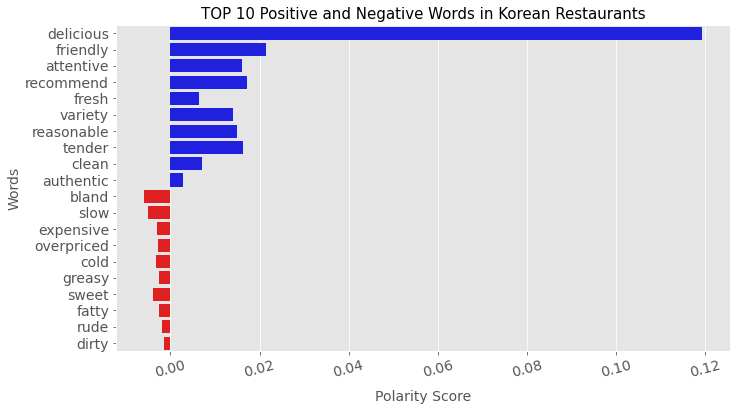

In [56]:
plt.figure(figsize=(11,6))
colors = ['red' if c < 0 else 'blue' for c in Korean_top_words.values]
sns.barplot(y=Korean_top_words.index, x=Korean_top_words.values, palette=colors)
plt.xlabel('Polarity Score', labelpad=10, fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.title('TOP 10 Positive and Negative Words in Korean Restaurants', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)

In [57]:
def get_polarity_score(dataset):
    dataset.text = dataset.text.apply(filter_words)
    
    terms_train=list(dataset['text'])
    class_train=list(dataset['labels'])
    
    ## get bag of words
    vectorizer = CountVectorizer()
    feature_train_counts=vectorizer.fit_transform(terms_train)
    
    ## run model
    svm = LinearSVC()
    svm.fit(feature_train_counts, class_train)
    
    ## create dataframe for score of each word in a review calculated by svm model
    coeff = svm.coef_[0]
    cuisine_words_score = pd.DataFrame({'score': coeff, 'word': vectorizer.get_feature_names()})
    
    ## get frequency of each word in all reviews in specific category
    cuisine_reviews = pd.DataFrame(feature_train_counts.toarray(), columns=vectorizer.get_feature_names())
    cuisine_reviews['labels'] = class_train
    cuisine_frequency = cuisine_reviews[cuisine_reviews['labels'] =='positive'].sum()[:-1]
    
    cuisine_words_score.set_index('word', inplace=True)
    cuisine_polarity_score = cuisine_words_score
    cuisine_polarity_score['frequency'] = cuisine_frequency
    
    cuisine_polarity_score.score = cuisine_polarity_score.score.astype(float)
    cuisine_polarity_score.frequency = cuisine_polarity_score.frequency.astype(int)
    
    ## calculate polarity score 
    cuisine_polarity_score['polarity'] = cuisine_polarity_score.score * cuisine_polarity_score.frequency / cuisine_reviews.shape[0]
    
    cuisine_polarity_score.polarity = cuisine_polarity_score.polarity.astype(float)
    ## drop unnecessary words
    unuseful_positive_words = ['great','amazing','love','best','awesome','excellent','good',
                                                   'favorite','loved','perfect','gem','perfectly','wonderful',
                                                    'happy','enjoyed','nice','well','super','like','better','decent','fine',
                                                    'pretty','enough','excited','impressed','ready','fantastic','glad','right',
                                                    'fabulous']
    unuseful_negative_words =  ['bad','disappointed','unfortunately','disappointing','horrible',
                                                    'lacking','terrible','sorry']
    unuseful_words = unuseful_positive_words + unuseful_negative_words
    cuisine_polarity_score.drop(cuisine_polarity_score.loc[unuseful_words].index, axis=0, inplace=True)
    
    return cuisine_polarity_score

In [58]:
def plot_top_words(top_words, category):
    plt.figure(figsize=(11,6))
    colors = ['red' if c < 0 else 'blue' for c in top_words.values]
    sns.barplot(y=top_words.index, x=top_words.values, palette=colors)
    plt.xlabel('Polarity Score', labelpad=10, fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.title('TOP 10 Positive and Negative Words in %s Restaurants ' % category, fontsize=15)
    plt.tick_params(labelsize=14)
    plt.xticks(rotation=15)

In [59]:
def get_top_words(dataset, label, number=20):
    if label == 'positive':
        df = dataset[dataset.polarity>0].sort_values('polarity',ascending = False)[:number]
    else:
        df = dataset[dataset.polarity<0].sort_values('polarity')[:number]
    return df

#### Japanese

In [60]:
Japanese_reviews = get_dataset('Japanese')
Japanese_train = split_data(Japanese_reviews, 0.9)
print('Total %d number of reviews' % Japanese_train.shape[0])

Total 11537 number of reviews


In [61]:
Japanese_polarity_score = get_polarity_score(Japanese_train)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [62]:
get_top_words(Japanese_polarity_score, 'positive')

,score,frequency,polarity
word,,,
delicious,0.5656,2019,0.0990
fresh,0.1537,2242,0.0299
friendly,0.2071,1455,0.0261
variety,0.5146,371,0.0165
incredible,0.9174,192,0.0153
reasonable,0.4328,332,0.0125
recommend,0.1302,1056,0.0119
attentive,0.2324,512,0.0103
affordable,0.8209,141,0.0100


In [63]:
get_top_words(Japanese_polarity_score,'negative',20)

,score,frequency,polarity
word,,,
cold,-0.2654,271,-0.0062
bland,-0.8986,62,-0.0048
slow,-0.3594,153,-0.0048
wrong,-0.2673,202,-0.0047
expensive,-0.1836,241,-0.0038
hate,-0.6085,61,-0.0032
mediocre,-1.1095,32,-0.0031
honest,-0.8985,38,-0.0030
warm,-0.1639,206,-0.0029


In [64]:
Japanese_top_positive_words = ['delicious','friendly','fresh','recommend','fun','reasonable',
                               'creative','clean','variety','attentive']
Japanese_top_negative_words = ['hard','cold','wrong','slow','bland','dark','expensive',
                               'rude','overpriced','crowded']
Japanese_top_words = Japanese_polarity_score.loc[Japanese_top_positive_words+Japanese_top_negative_words,'polarity']

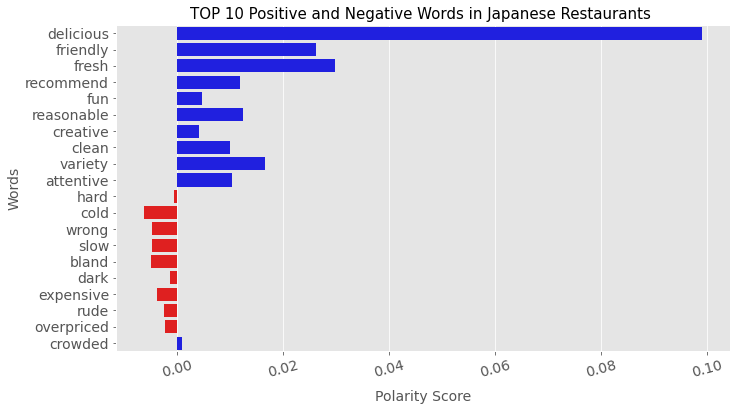

In [65]:
plot_top_words(Japanese_top_words,'Japanese')

#### Thai

In [66]:
Thai_reviews = get_dataset('Thai')
Thai_train = split_data(Thai_reviews, 0.8)
print('Total %d number of reviews' % Thai_train.shape[0])

Total 12420 number of reviews


In [67]:
Thai_polarity_score = get_polarity_score(Thai_train)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [68]:
get_top_words(Thai_polarity_score,'positive')

,score,frequency,polarity
word,,,
delicious,0.8390,2723,0.1839
friendly,0.3234,1698,0.0442
fresh,0.1562,1324,0.0166
outstanding,0.8521,203,0.0139
recommend,0.1451,1146,0.0134
hot,0.1136,1400,0.0128
attentive,0.3609,432,0.0126
perfection,1.2028,124,0.0120
authentic,0.1827,752,0.0111


In [69]:
get_top_words(Thai_polarity_score,'negative')

,score,frequency,polarity
word,,,
bland,-0.8477,87,-0.0059
sour,-0.1835,308,-0.0046
slow,-0.2802,187,-0.0042
top,-0.1283,396,-0.0041
cold,-0.3438,146,-0.0040
greasy,-0.5150,95,-0.0039
hard,-0.1585,296,-0.0038
problem,-0.3690,104,-0.0031
expensive,-0.3125,122,-0.0031


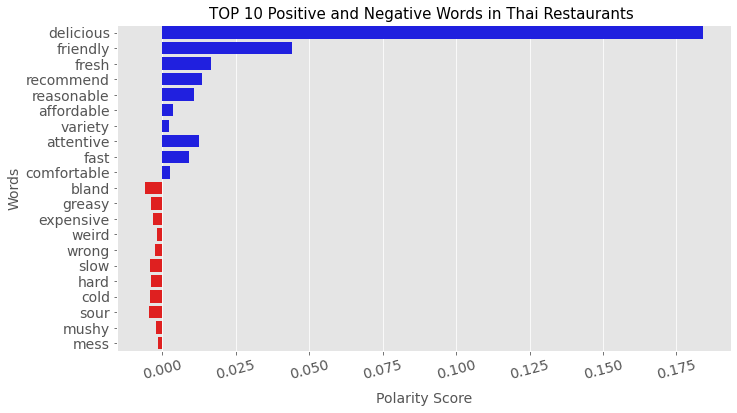

In [70]:
Thai_top_positive_words = ['delicious','friendly','fresh','recommend','reasonable','affordable','variety',
                           'attentive','fast','comfortable']
Thai_top_negative_words = ['bland','greasy','expensive','weird','wrong','slow','hard','cold','sour','mushy','mess']
Thai_top_words = Thai_polarity_score.loc[Thai_top_positive_words+Thai_top_negative_words,'polarity']
plot_top_words(Thai_top_words, 'Thai')

#### Chinese

In [71]:
Chinese_reviews = get_dataset('Chinese')
Chinese_train = split_data(Chinese_reviews, 0.85)
print('Total %d number of reviews' % Chinese_train.shape[0])

Total 15006 number of reviews


In [72]:
Chinese_polarity_score = get_polarity_score(Chinese_train)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [73]:
get_top_words(Chinese_polarity_score,'positive')

,score,frequency,polarity
word,,,
delicious,0.7059,2210,0.1040
friendly,0.3441,1623,0.0372
fresh,0.2848,1731,0.0329
authentic,0.2924,842,0.0164
recommend,0.2013,1134,0.0152
fast,0.2133,952,0.0135
reasonable,0.4401,428,0.0126
hot,0.1069,1747,0.0124
pleasantly,0.9288,136,0.0084


In [74]:
get_top_words(Chinese_polarity_score,'negative')

,score,frequency,polarity
word,,,
sour,-0.1699,798,-0.0090
bland,-0.8681,128,-0.0074
cold,-0.3742,227,-0.0057
hard,-0.2388,316,-0.0050
greasy,-0.3122,207,-0.0043
fried,-0.0263,2190,-0.0038
wrong,-0.2454,224,-0.0037
weird,-0.4926,99,-0.0032
prefer,-0.4077,103,-0.0028


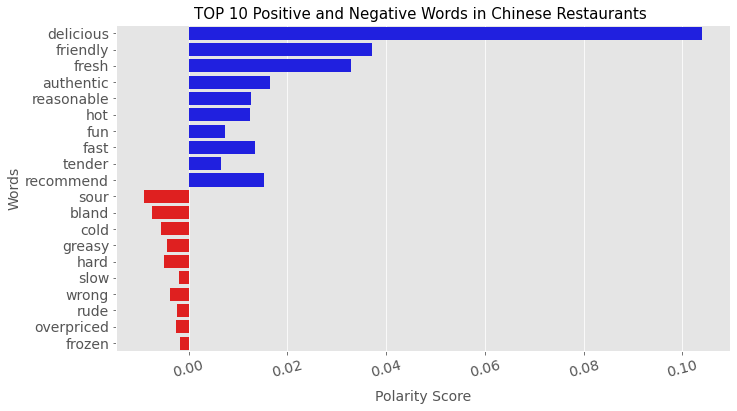

In [75]:
Chinese_top_positive_words = ['delicious','friendly','fresh','authentic','reasonable','hot','fun',
                           'fast','tender','recommend']
Chinese_top_negative_words = ['sour','bland','cold','greasy','hard','slow','wrong','rude','overpriced','frozen']
Chinese_top_words = Chinese_polarity_score.loc[Chinese_top_positive_words+Chinese_top_negative_words,'polarity']
plot_top_words(Chinese_top_words, 'Chinese')

#### Vietnamese

In [76]:
Vietnamese_reviews = get_dataset('Vietnamese')
Vietnamese_train = split_data(Vietnamese_reviews, 0.7)
print('Total %d number of reviews' % Vietnamese_train.shape[0])

Total 12072 number of reviews


In [77]:
Vietnamese_polarity_score = get_polarity_score(Vietnamese_train)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [78]:
get_top_words(Vietnamese_polarity_score,'positive')

,score,frequency,polarity
word,,,
delicious,0.6319,2387,0.1249
friendly,0.2297,1678,0.0319
fresh,0.1497,2016,0.0250
attentive,0.5769,419,0.0200
fast,0.3195,730,0.0193
clean,0.1995,1138,0.0188
tender,0.6915,299,0.0171
reasonable,0.5028,346,0.0144
variety,0.6257,250,0.0130


In [79]:
get_top_words(Vietnamese_polarity_score,'negative')

,score,frequency,polarity
word,,,
bland,-0.8081,87,-0.0058
wrong,-0.2813,230,-0.0054
greasy,-0.6832,74,-0.0042
hard,-0.1422,335,-0.0039
fried,-0.0441,1060,-0.0039
slow,-0.2604,168,-0.0036
expensive,-0.4189,103,-0.0036
dirty,-0.6498,60,-0.0032
sour,-0.2685,125,-0.0028


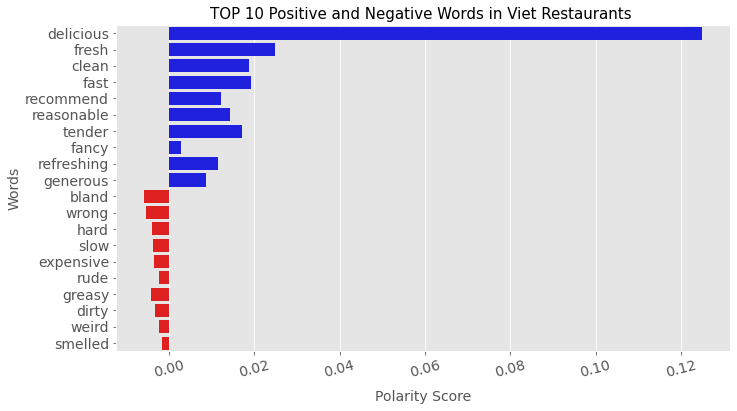

In [80]:
Viet_top_positive_words = ['delicious','fresh','clean','fast','recommend','reasonable','tender',
                           'fancy','refreshing','generous']
Viet_top_negative_words = ['bland','wrong','hard','slow','expensive','rude','greasy','dirty','weird','smelled']
Viet_top_words = Vietnamese_polarity_score.loc[Viet_top_positive_words+Viet_top_negative_words,'polarity']
plot_top_words(Viet_top_words,'Viet')

#### French

In [81]:
French_reviews = get_dataset('French')
French_train = split_data(French_reviews, 0.7)
print('Total %d number of reviews' % French_train.shape[0])

Total 13083 number of reviews


In [82]:
French_polarity_score = get_polarity_score(French_train)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [83]:
get_top_words(French_polarity_score,'positive')

,score,frequency,polarity
word,,,
delicious,0.5520,3615,0.1525
fresh,0.2355,1638,0.0295
incredible,0.7277,449,0.0250
die,0.7672,383,0.0225
worth,0.1865,1278,0.0182
tender,0.3797,587,0.0170
perfection,0.5474,392,0.0164
helpful,0.5548,357,0.0151
lemon,0.4567,431,0.0150


In [84]:
get_top_words(French_polarity_score, 'negative')

,score,frequency,polarity
word,,,
cold,-0.6357,273,-0.0133
top,-0.1346,1166,-0.0120
hard,-0.2189,477,-0.0080
slow,-0.3937,221,-0.0067
overpriced,-0.8000,98,-0.0060
wrong,-0.2080,313,-0.0050
bland,-0.8280,78,-0.0049
work,-0.1940,330,-0.0049
expensive,-0.1348,412,-0.0042


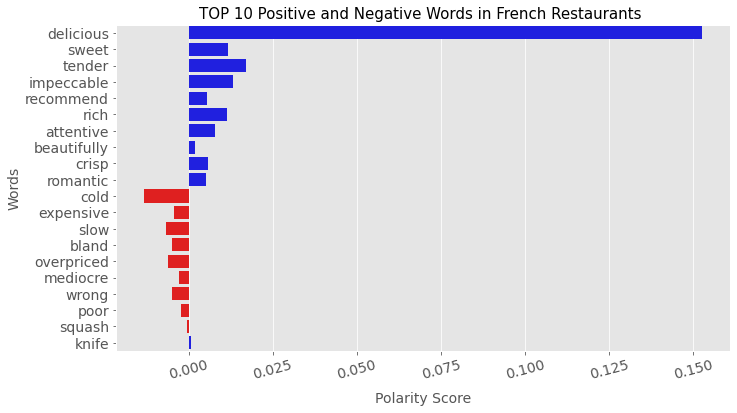

In [85]:
French_top_positive_words = ['delicious','sweet','tender','impeccable','recommend','rich','attentive',
                             'beautifully','crisp','romantic']
French_top_negative_words = ['cold','expensive','slow','bland','overpriced','mediocre','wrong',
                             'poor','squash','knife']
French_top_words = French_polarity_score.loc[French_top_positive_words+French_top_negative_words,'polarity']
plot_top_words(French_top_words,'French')

#### Italian

In [86]:
Italian_reviews = get_dataset('Italian')
Italian_train = split_data(Italian_reviews, 0.9)
print('Total %d number of reviews' % Italian_train.shape[0])

Total 19828 number of reviews


In [87]:
Italian_polarity_score = get_polarity_score(Italian_train)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [88]:
get_top_words(Italian_polarity_score, 'positive',30)

,score,frequency,polarity
word,,,
delicious,0.5408,3731,0.1018
friendly,0.3161,2349,0.0374
fresh,0.2832,2395,0.0342
die,0.9141,377,0.0174
recommend,0.1699,1625,0.0139
outstanding,0.4547,524,0.0120
pleasantly,1.1920,179,0.0108
superb,0.9996,197,0.0099
incredible,0.4879,402,0.0099


In [89]:
get_top_words(Italian_polarity_score, 'negative',30)

,score,frequency,polarity
word,,,
hard,-0.1992,481,-0.0048
wrong,-0.2237,371,-0.0042
bland,-1.0562,77,-0.0041
cold,-0.3045,264,-0.0041
slow,-0.3448,224,-0.0039
problem,-0.3467,211,-0.0037
warm,-0.1394,486,-0.0034
expensive,-0.2446,267,-0.0033
lemon,-0.2010,289,-0.0029


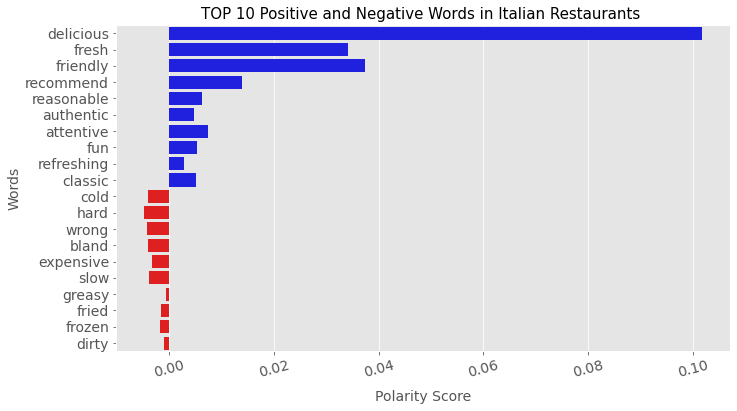

In [90]:
Italian_top_positive_words = ['delicious','fresh','friendly','recommend','reasonable','authentic',
                             'attentive','fun','refreshing','classic']
Italian_top_negative_words = ['cold','hard','wrong','bland','expensive','slow','greasy','fried','frozen','dirty']
Italian_top_words = Italian_polarity_score.loc[Italian_top_positive_words+Italian_top_negative_words,'polarity']
plot_top_words(Italian_top_words,'Italian')

### Combine all top words to compare among different cuisine typies

In [91]:
all_category = {'cuisine':['Korean','Japanese','Chinese','Thai','Vietnamese','French','Italian']}
cuisine_positive_words = pd.DataFrame(all_category)
for i,word in enumerate(Korean_top_positive_words):
    cuisine_positive_words.loc[0,i] = word

In [92]:
for i,word in enumerate(Korean_top_positive_words):
    cuisine_positive_words.iloc[0,i] = word
for i,word in enumerate(Japanese_top_positive_words):
    cuisine_positive_words.iloc[1,i] = word
for i,word in enumerate(Chinese_top_positive_words):
    cuisine_positive_words.iloc[2,i] = word
for i,word in enumerate(Thai_top_positive_words):
    cuisine_positive_words.iloc[3,i] = word
for i,word in enumerate(Viet_top_positive_words):
    cuisine_positive_words.iloc[4,i] = word
for i,word in enumerate(French_top_positive_words):
    cuisine_positive_words.iloc[5,i] = word
for i,word in enumerate(Italian_top_positive_words):
    cuisine_positive_words.iloc[6,i] = word

cuisine_positive_words.drop(9,axis=1,inplace=True)
cuisine_positive_words.columns=['0','1','2','3','4','5','6','7','8','9']
cuisine_positive_words['cuisine']=['Korean','Japanese','Chinese','Thai','Vietnamese','French','Italian']
cuisine_positive_words.set_index('cuisine', inplace=True)

In [93]:
all_category = {'cuisine':['Korean','Japanese','Chinese','Thai','Vietnamese','French','Italian']}
cuisine_negative_words = pd.DataFrame(all_category)
for i,word in enumerate(Korean_top_negative_words):
    cuisine_negative_words.loc[0,i] = word

In [94]:
for i,word in enumerate(Korean_top_negative_words):
    cuisine_negative_words.iloc[0,i] = word
for i,word in enumerate(Japanese_top_negative_words):
    cuisine_negative_words.iloc[1,i] = word
for i,word in enumerate(Chinese_top_negative_words):
    cuisine_negative_words.iloc[2,i] = word
for i,word in enumerate(Thai_top_negative_words):
    cuisine_negative_words.iloc[3,i] = word
for i,word in enumerate(Viet_top_negative_words):
    cuisine_negative_words.iloc[4,i] = word
for i,word in enumerate(French_top_negative_words):
    cuisine_negative_words.iloc[5,i] = word
for i,word in enumerate(Italian_top_negative_words):
    cuisine_negative_words.iloc[6,i] = word

cuisine_negative_words.drop(9,axis=1,inplace=True)
cuisine_negative_words.columns=['0','1','2','3','4','5','6','7','8','9']
cuisine_negative_words['cuisine']=['Korean','Japanese','Chinese','Thai','Vietnamese','French','Italian']
cuisine_negative_words.set_index('cuisine', inplace=True)

In [98]:
cuisine_positive_words

,0,1,2,3,4,5,6,7,8,9
cuisine,,,,,,,,,,
Korean,delicious,friendly,attentive,recommend,fresh,variety,reasonable,tender,clean,authentic
Japanese,delicious,friendly,fresh,recommend,fun,reasonable,creative,clean,variety,attentive
Chinese,delicious,friendly,fresh,authentic,reasonable,hot,fun,fast,tender,recommend
Thai,delicious,friendly,fresh,recommend,reasonable,affordable,variety,attentive,fast,comfortable
Vietnamese,delicious,fresh,clean,fast,recommend,reasonable,tender,fancy,refreshing,generous
French,delicious,sweet,tender,impeccable,recommend,rich,attentive,beautifully,crisp,romantic
Italian,delicious,fresh,friendly,recommend,reasonable,authentic,attentive,fun,refreshing,classic


In [99]:
cuisine_negative_words

,0,1,2,3,4,5,6,7,8,9
cuisine,,,,,,,,,,
Korean,bland,slow,expensive,overpriced,cold,greasy,sweet,fatty,rude,dirty
Japanese,hard,cold,wrong,slow,bland,dark,expensive,rude,overpriced,crowded
Chinese,sour,bland,cold,greasy,hard,slow,wrong,rude,overpriced,frozen
Thai,bland,greasy,expensive,weird,wrong,slow,hard,cold,sour,mushy
Vietnamese,bland,wrong,hard,slow,expensive,rude,greasy,dirty,weird,smelled
French,cold,expensive,slow,bland,overpriced,mediocre,wrong,poor,squash,knife
Italian,cold,hard,wrong,bland,expensive,slow,greasy,fried,frozen,dirty
